### 1.1 Import

In [1]:
import pandas as pd
import numpy as np

import re
from urllib.parse import urlparse
from collections import Counter
import math


### 1.2 Load CSV

In [2]:
file_path = "./Dataset/Mendely 2 Phishing URL dataset/URL dataset.csv"

df = pd.read_csv(file_path)

### 1.3 Quick Check

In [3]:
df.head()
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   type    450176 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


(450176, 2)

### 2.0 Cleaning
### 2.1 Standardise column name

In [4]:
df.columns = df.columns.str.lower().str.strip()
df.columns


Index(['url', 'type'], dtype='object')

### 2.2 Check missing values

In [5]:
df.isnull().sum()

url     0
type    0
dtype: int64

### 2.3 Normalize labels

In [6]:
df["label"] = df["type"].map({
    "legitimate": 0,
    "phishing": 1
})

print(df["label"].value_counts())
print(df['label'].count())

label
0    345738
1    104438
Name: count, dtype: int64
450176


### 2.4 Remove duplicates

In [7]:
df.duplicated(subset=["url"]).sum()


np.int64(0)

In [8]:
df = df.drop_duplicates(subset=["url"]).reset_index(drop=True)


In [9]:
df.shape

(450176, 3)

### 2.5 Basic URL sanity cleaning

In [10]:
df["url"] = (
    df["url"]
    .astype(str)
    .str.strip()
    .str.strip('"')
    .str.strip("'")
)

df = df[df["url"].str.startswith(("http://", "https://"))]

def try_parse(url: str):
    try:
        urlparse(url)
        return True
    except ValueError:
        return False

bad_mask = ~df["url"].astype(str).apply(try_parse)
print("Bad URLs:", bad_mask.sum())

# Inspect them
print(df.loc[bad_mask, "url"].head(30).apply(repr))

df = df.loc[~bad_mask].reset_index(drop=True)

print(df.shape)

Bad URLs: 1
397556    'http://ladiesfirst-privileges[.]com/656465/d5...
Name: url, dtype: object
(450132, 3)


### 3.0 Feature Extraction

### 3.1 Helper functions

In [11]:
def shannon_entropy(s):
    if not s:
        return 0
    counts = Counter(s)
    probs = [count / len(s) for count in counts.values()]
    return -sum(p * math.log2(p) for p in probs)


### 3.2 Core feature extractor v1 & v2

In [12]:
import tldextract

# ---------- Regex ----------
_IPV4_RE = re.compile(r"\b\d{1,3}(\.\d{1,3}){3}\b")
_ENCODED_RE = re.compile(r"%[0-9a-fA-F]{2}")

# ---------- Keywords ----------
SUSPICIOUS_KEYWORDS = sorted(set([
    "account", "confirm", "banking", "secure", "ebyisapi", "webscr",
    "signin", "mail", "install", "toolbar", "backup", "paypal",
    "password", "username", "verify", "update", "login", "support",
    "billing", "transaction", "security", "payment", "online",
    "customer", "service", "accountupdate", "verification",
    "important", "confidential", "limited", "access",
    "securitycheck", "verifyaccount", "information", "change",
    "notice", "myaccount", "updateinfo", "loginsecure", "protect",
    "identity", "member", "personal", "actionrequired",
    "loginverify", "validate", "paymentupdate", "urgent"
]))

COMMON_TLDS = {
    "com", "org", "net", "edu", "gov", "mil",
    "co", "io", "uk", "us", "de", "jp", "fr", "ai",
    "in", "gg",
}

SUSPICIOUS_EXTENSIONS = {
    ".exe", ".dll", ".scr", ".bat", ".cmd", ".sh",
    ".js", ".vbs", ".ps1",
    ".zip", ".rar", ".7z", ".gz", ".tar",
    ".apk", ".msi", ".iso",
    ".php", ".html", ".htm"  # optional (phishing landing pages)
}

# ---------- Domain helpers ----------
def get_registered_domain(url: str) -> str:
    """
    Returns registrable domain like 'google.com' from any URL or hostname.
    """
    ext = tldextract.extract(url)
    if ext.domain and ext.suffix:
        return f"{ext.domain}.{ext.suffix}"
    return ""

def tokenize_url(url: str):
    return re.split(r"[\/\.\-_?=&]", url)

def keyword_features(url: str, keywords=SUSPICIOUS_KEYWORDS) -> dict:
    url_l = url.lower()
    hits = [kw for kw in keywords if kw in url_l]
    return {
        "has_any_suspicious_keyword": int(len(hits) > 0),
        "num_suspicious_keywords": len(hits),
        "max_suspicious_keyword_length": max((len(k) for k in hits), default=0),
        "keyword_density": len(hits) / max(len(url), 1),
    }

def extract_features(url: str, version: str = "v2", include_reg_domain_features: bool = True) -> dict:
    """
    Single entry point:
    - version='v1' or 'v2'
    - optionally include registered-domain-level features
    """
    url = str(url).strip()
    p = urlparse(url)

    netloc = p.netloc or ""
    path = p.path or ""
    query = p.query or ""
    scheme = (p.scheme or "").lower()

    path_lower = path.lower()
    has_suspicious_extension = int(
        any(path_lower.endswith(ext) for ext in SUSPICIOUS_EXTENSIONS)
    )


    ext = tldextract.extract(url)
    tld = ext.suffix or ""

    # ---------- v1 base features ----------
    features = {
        "url_length": len(url),
        "domain_length": len(netloc),
        "path_length": len(path),
        "query_length": len(query),

        "num_dots": url.count("."),
        "num_hyphens": url.count("-"),
        "num_digits": sum(c.isdigit() for c in url),
        "num_slashes": url.count("/"),
        "num_subdomains": netloc.count("."),

        # Query symbols (explicit)
        "num_question_marks": url.count("?"),
        "num_equals": url.count("="),
        "num_ampersands": url.count("&"),
        "has_query": int("?" in url),
        "num_special_chars": sum(not c.isalnum() for c in url),

        # TLD features
        "tld_length": len(tld),
        "is_common_tld": int(tld in COMMON_TLDS),

        "is_https": int(scheme == "https"),
        "has_ipv4": int(bool(_IPV4_RE.search(netloc))),
        "suspicious_file_extension": has_suspicious_extension,

        "entropy": shannon_entropy(url),
    }

    if version == "v1":
        return features

    # ---------- v2 extras ----------
    tokens = tokenize_url(url.lower())
    url_len = max(len(url), 1)

    features.update({
        "digit_ratio": features["num_digits"] / url_len,
        "letter_ratio": sum(c.isalpha() for c in url) / url_len,
        "special_char_ratio": features["num_special_chars"] / url_len,
    })

    features.update(keyword_features(url, SUSPICIOUS_KEYWORDS))

    encoded_matches = _ENCODED_RE.findall(url)
    features.update({
        "num_encoded_chars": len(encoded_matches),
        "has_url_encoding": int(len(encoded_matches) > 0),
        "longest_token_length": max((len(t) for t in tokens if t), default=0),
    })

    return features



### 3.3 Apply feature extraction

In [13]:
features_v1 = pd.DataFrame(df["url"].apply(lambda u: extract_features(u, version="v1")).tolist())


features_v2 = pd.DataFrame(df["url"].apply(lambda u: extract_features(u, version="v2")).tolist())

print("v1 shape:", features_v1.shape)
print("v2 shape:", features_v2.shape)
print("v2 extra features:", set(features_v2.columns) - set(features_v1.columns))

v1 shape: (450132, 20)
v2 shape: (450132, 30)
v2 extra features: {'has_url_encoding', 'has_any_suspicious_keyword', 'num_encoded_chars', 'digit_ratio', 'letter_ratio', 'num_suspicious_keywords', 'longest_token_length', 'max_suspicious_keyword_length', 'special_char_ratio', 'keyword_density'}


### 3.4 Combine features + label

In [14]:
Xy_v1 = pd.concat([features_v1, df["label"]], axis=1)

Xy_v2 = pd.concat([features_v2, df["label"]], axis=1)

print("v1 shape:", Xy_v1.shape)
print("v2 shape:", Xy_v2.shape)
print("v2 extra features:", set(features_v2.columns) - set(features_v1.columns))

v1 shape: (450132, 21)
v2 shape: (450132, 31)
v2 extra features: {'has_url_encoding', 'has_any_suspicious_keyword', 'num_encoded_chars', 'digit_ratio', 'letter_ratio', 'num_suspicious_keywords', 'longest_token_length', 'max_suspicious_keyword_length', 'special_char_ratio', 'keyword_density'}


### 4.0 Quality Check

### 4.1 Shape check

In [15]:
print("df shape:", df.shape)
print("features v1 shape:", features_v1.shape)
print("features v2 shape:", features_v2.shape)

print("Xy_v1 shape:", Xy_v1.shape)
print("Xy_v2 shape:", Xy_v2.shape)

df shape: (450132, 3)
features v1 shape: (450132, 20)
features v2 shape: (450132, 30)
Xy_v1 shape: (450132, 21)
Xy_v2 shape: (450132, 31)


### 4.2 Missing values

In [16]:
na_counts = Xy_v2.isna().sum().sort_values(ascending=False)
na_counts.head(30)

url_length                       0
is_https                         0
longest_token_length             0
has_url_encoding                 0
num_encoded_chars                0
keyword_density                  0
max_suspicious_keyword_length    0
num_suspicious_keywords          0
has_any_suspicious_keyword       0
special_char_ratio               0
letter_ratio                     0
digit_ratio                      0
entropy                          0
suspicious_file_extension        0
has_ipv4                         0
is_common_tld                    0
domain_length                    0
tld_length                       0
num_special_chars                0
has_query                        0
num_ampersands                   0
num_equals                       0
num_question_marks               0
num_subdomains                   0
num_slashes                      0
num_digits                       0
num_hyphens                      0
num_dots                         0
query_length        

### 4.3 Duplicate rows in features

In [17]:
dup_rows_v1 = Xy_v1.duplicated().sum()
dup_rows_v2 = Xy_v2.duplicated().sum()
print("Duplicate feature rows v1:", dup_rows_v1)
print("Duplicate feature rows v2:", dup_rows_v2)

Duplicate feature rows v1: 89754
Duplicate feature rows v2: 83279


### 4.4 Label balance

In [18]:
Xy_v2["label"].value_counts(), Xy_v2["label"].value_counts(normalize=True)

(label
 0    345702
 1    104430
 Name: count, dtype: int64,
 label
 0    0.768001
 1    0.231999
 Name: proportion, dtype: float64)

### 4.5 Basic sanity ranges (catch bugs)

In [19]:
summary = Xy_v2.describe().T
display(summary[["min", "max", "mean"]])

,min,max,mean
url_length,8.000000,2314.000000,60.240021
domain_length,0.000000,240.000000,19.295262
path_length,0.000000,1897.000000,27.437880
query_length,0.000000,2245.000000,5.537582
num_dots,0.000000,32.000000,2.620580
num_hyphens,0.000000,42.000000,1.252015
num_digits,0.000000,631.000000,4.194367
num_slashes,2.000000,46.000000,4.444108
num_subdomains,0.000000,20.000000,2.121091
num_question_marks,0.000000,166.000000,0.152866


In [20]:
mask_dom0 = features_v2["domain_length"] == 0
print("domain_length == 0 rows:", mask_dom0.sum())
print("percentage:", mask_dom0.mean() * 100)
df.loc[mask_dom0, "url"].head(30).apply(repr)

domain_length == 0 rows: 3
percentage: 0.0006664711684572526


385955                           'http://#NAME?'
389307                                'http://?'
399319    'http://?guid=Windows Updates Manager'
Name: url, dtype: object

In [21]:
# Count how many unique label values per feature vector
feat_cols = [c for c in Xy_v2.columns if c != "label"]
label_variation = Xy_v2.groupby(feat_cols)["label"].nunique()

print("Feature vectors mapping to 1 label:", (label_variation == 1).sum())
print("Feature vectors mapping to BOTH labels:", (label_variation > 1).sum())

Feature vectors mapping to 1 label: 366639
Feature vectors mapping to BOTH labels: 107


### 5.0 Model Training

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

In [23]:
%pip install xgboost
from xgboost import XGBClassifier

Note: you may need to restart the kernel to use updated packages.


### 5.1. Prepare X / y for v1 and v2

In [24]:
def split_xy(df):
    X = df.drop(columns=["label"])
    y = df["label"]
    return X, y

X_v1, y_v1 = split_xy(Xy_v1)
X_v2, y_v2 = split_xy(Xy_v2)

### 5.2 Stratified Train / Test Split

In [25]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_v1, y_v1,
    test_size=0.2,
    stratify=y_v1,
    random_state=42
)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_v2, y_v2,
    test_size=0.2,
    stratify=y_v2,
    random_state=42
)

### 5.3 Baseline Models
3.1 Random Forest (baseline)

In [26]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

3.2 AdaBoost

In [27]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

3.3 XGBoost

In [28]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

In [29]:
def train_and_eval(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)

    print(f"\n===== {name} =====")
    print("ROC-AUC:", round(auc, 4))
    print(classification_report(y_test, y_pred))

    return {
        "model": model,
        "auc": auc,
        "y_proba": y_proba
    }

### 5.4 Compare v1 vs v2 (Same Model)

In [30]:
rf_v1 = train_and_eval(rf, X1_train, y1_train, X1_test, y1_test, "RF v1")
rf_v2 = train_and_eval(rf, X2_train, y2_train, X2_test, y2_test, "RF v2")

ada_v1 = train_and_eval(ada, X1_train, y1_train, X1_test, y1_test, "Ada v1")
ada_v2 = train_and_eval(ada, X2_train, y2_train, X2_test, y2_test, "Ada v2")

xgb_v1 = train_and_eval(xgb, X1_train, y1_train, X1_test, y1_test, "XGB v1")
xgb_v2 = train_and_eval(xgb, X2_train, y2_train, X2_test, y2_test, "XGB v2")



===== RF v1 =====
ROC-AUC: 0.9973
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69141
           1       1.00      0.98      0.99     20886

    accuracy                           0.99     90027
   macro avg       1.00      0.99      0.99     90027
weighted avg       0.99      0.99      0.99     90027


===== RF v2 =====
ROC-AUC: 0.9986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69141
           1       1.00      0.98      0.99     20886

    accuracy                           1.00     90027
   macro avg       1.00      0.99      0.99     90027
weighted avg       1.00      1.00      1.00     90027


===== Ada v1 =====
ROC-AUC: 0.9963
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69141
           1       1.00      0.96      0.98     20886

    accuracy                           0.99     90027
   macro avg       0.9

### 5.5 ROC Curve Comparison (v1 vs v2)

In [31]:
def plot_roc(y_test, results, title):
    plt.figure(figsize=(6,5))

    for label, res in results.items():
        fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
        plt.plot(fpr, tpr, label=f"{label} (AUC={res['auc']:.3f})")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

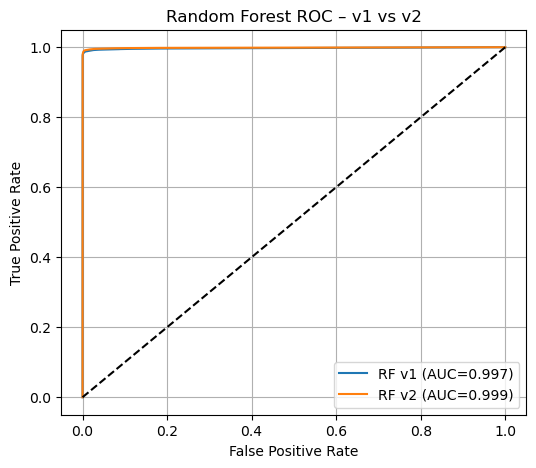

In [32]:
plot_roc(
    y1_test,
    {"RF v1": rf_v1, "RF v2": rf_v2},
    "Random Forest ROC – v1 vs v2"
)

### 6. Robustness Evaluation: Domain-Aware Split 

 6.1 Domain Extraction

In [33]:
%pip install tldextract

Note: you may need to restart the kernel to use updated packages.


In [34]:
df["domain"] = df["url"].apply(get_registered_domain)

print("Unique domains:\n", df["domain"].head())

Unique domains:
 0       google.com
1      youtube.com
2     facebook.com
3        baidu.com
4    wikipedia.org
Name: domain, dtype: object


6.2 Domain-Aware Split (Code)

In [35]:
from sklearn.model_selection import train_test_split

domains = df["domain"].unique()

train_domains, test_domains = train_test_split(
    domains,
    test_size=0.2,
    random_state=42
)

train_mask = df["domain"].isin(train_domains)
test_mask  = df["domain"].isin(test_domains)

df_train = df[train_mask]
df_test  = df[test_mask]

# Sanity check
assert set(df_train["domain"]).isdisjoint(set(df_test["domain"]))

In [36]:
display(df.head())

,url,type,label,domain
0,https://www.google.com,legitimate,0,google.com
1,https://www.youtube.com,legitimate,0,youtube.com
2,https://www.facebook.com,legitimate,0,facebook.com
3,https://www.baidu.com,legitimate,0,baidu.com
4,https://www.wikipedia.org,legitimate,0,wikipedia.org


6.3 Rebuild v1 / v2 Splits (Code)

In [37]:
Xy_v1_train = Xy_v1.loc[df_train.index]
Xy_v1_test  = Xy_v1.loc[df_test.index]

Xy_v2_train = Xy_v2.loc[df_train.index]
Xy_v2_test  = Xy_v2.loc[df_test.index]

def split_xy(df):
    return df.drop(columns=["label"]), df["label"]

X1_train, y1_train = split_xy(Xy_v1_train)
X1_test,  y1_test  = split_xy(Xy_v1_test)

X2_train, y2_train = split_xy(Xy_v2_train)
X2_test,  y2_test  = split_xy(Xy_v2_test)

In [38]:
X2_train.head()

,url_length,domain_length,path_length,query_length,num_dots,num_hyphens,num_digits,num_slashes,num_subdomains,num_question_marks,...,digit_ratio,letter_ratio,special_char_ratio,has_any_suspicious_keyword,num_suspicious_keywords,max_suspicious_keyword_length,keyword_density,num_encoded_chars,has_url_encoding,longest_token_length
1,23,15,0,0,2,0,0,2,2,0,...,0.0,0.782609,0.217391,0,0,0,0.0,0,0,7
2,24,16,0,0,2,0,0,2,2,0,...,0.0,0.791667,0.208333,0,0,0,0.0,0,0,8
3,21,13,0,0,2,0,0,2,2,0,...,0.0,0.761905,0.238095,0,0,0,0.0,0,0,6
5,22,14,0,0,2,0,0,2,2,0,...,0.0,0.772727,0.227273,0,0,0,0.0,0,0,6
6,21,13,0,0,2,0,0,2,2,0,...,0.0,0.761905,0.238095,0,0,0,0.0,0,0,6


6.4 Retrain Models

In [39]:
rf_v1_domain = train_and_eval(
    rf,
    X1_train, y1_train,
    X1_test,  y1_test,
    "RF v1 (domain-aware)"
)

rf_v2_domain = train_and_eval(
    rf,
    X2_train, y2_train,
    X2_test,  y2_test,
    "RF v2 (domain-aware)"
)

ada_v1_domain = train_and_eval(
    ada,
    X1_train, y1_train,
    X1_test,  y1_test,
    "AdaBoost v1 (domain-aware)"
)

ada_v2_domain = train_and_eval(
    ada,
    X2_train, y2_train,
    X2_test,  y2_test,
    "AdaBoost v2 (domain-aware)"
)

xgb_v1_domain = train_and_eval(
    xgb,
    X1_train, y1_train,
    X1_test,  y1_test,
    "XGBoost v1 (domain-aware)"
)

xgb_v2_domain = train_and_eval(
    xgb,
    X2_train, y2_train,
    X2_test,  y2_test,
    "XGBoost v2 (domain-aware)"
)


===== RF v1 (domain-aware) =====
ROC-AUC: 0.9731
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     73514
           1       1.00      0.93      0.96     20799

    accuracy                           0.98     94313
   macro avg       0.99      0.96      0.97     94313
weighted avg       0.98      0.98      0.98     94313


===== RF v2 (domain-aware) =====
ROC-AUC: 0.9818
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     73514
           1       1.00      0.93      0.96     20799

    accuracy                           0.98     94313
   macro avg       0.99      0.96      0.98     94313
weighted avg       0.98      0.98      0.98     94313


===== AdaBoost v1 (domain-aware) =====
ROC-AUC: 0.972
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     73514
           1       0.99      0.92      0.96     20799

    accuracy               

In [40]:
print("RF v1 generalization gap:",
      round(rf_v1["auc"] - rf_v1_domain["auc"], 3))

print("RF v2 generalization gap:",
      round(rf_v2["auc"] - rf_v2_domain["auc"], 3))

RF v1 generalization gap: 0.024
RF v2 generalization gap: 0.017


## 7. External Dataset Evaluation (Cross-Source Validation)

### 7.1 — Load the External Datasets

7.1.1 Load Majestic Million (legitimate)

In [41]:
df_majestic = pd.read_csv("./Dataset/majestic_million.csv")

# Use only the domain column
df_majestic = df_majestic[["Domain"]].rename(columns={"Domain": "url"})
df_majestic["label"] = 0

def normalize_domain_to_url(domain):
    return "https://" + domain

df_majestic["url"] = df_majestic["url"].apply(normalize_domain_to_url)

7.1.2 Load OpenPhish (phishing)

In [42]:
openphish_urls = []

with open("./Dataset/openphish.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line and not line.startswith("#"):
            openphish_urls.append(line)

df_openphish = pd.DataFrame({"url": openphish_urls})
df_openphish["label"] = 1

7.1.3 Load URLHaus (phishing)

In [43]:
df_urlhaus = pd.read_csv(
    "./Dataset/URLHaus.txt",
    comment="#",
    header=None,
    names=[
        "id", "dateadded", "url", "url_status", "last_online",
        "threat", "tags", "urlhaus_link", "reporter"
    ]
)

df_urlhaus = df_urlhaus[["url"]]
df_urlhaus["label"] = 1

7.1.4 Combine External Test Set

In [44]:
df_external = pd.concat(
    [df_majestic, df_openphish, df_urlhaus],
    ignore_index=True
)

print(df_external["label"].value_counts())

label
0    1000000
1     142366
Name: count, dtype: int64


7.1.5 Another new Set of URL Dataset from Mendeley May 2025

In [45]:
df_ext_LegitPhish = pd.read_csv("Dataset/LegitPhishDataset.csv")

# Keep only URL + label
df_ext_LegitPhish = df_ext_LegitPhish[["URL", "ClassLabel"]].rename(columns={"URL": "url"})

# Drop rows with missing ClassLabel to avoid casting NaN to int
missing = df_ext_LegitPhish['ClassLabel'].isna().sum()
if missing:
	print(f"Dropping {missing} rows with missing ClassLabel")
	df_ext_LegitPhish = df_ext_LegitPhish.dropna(subset=["ClassLabel"]).copy()

# Convert to your label convention: phishing=1, legit=0
# Given: Phishing(0), Legitimate(1)
df_ext_LegitPhish["label"] = df_ext_LegitPhish["ClassLabel"].map({0: 1, 1: 0}).astype(int)

df_ext_LegitPhish.drop(columns=["ClassLabel"], inplace=True)

df_ext_LegitPhish["label"].value_counts()

Dropping 1 rows with missing ClassLabel


label
1    63678
0    37540
Name: count, dtype: int64

### 7.2 — Prevent Domain Overlap with Training

7.2.1 Extract registered domains

In [46]:
df_ext_LegitPhish["domain"] = df_ext_LegitPhish["url"].apply(get_registered_domain)

7.2.2 Remove overlapping domains

In [47]:
train_domains = set(df_train["domain"])

In [48]:
df_ext_LegitPhish["domain"] = df_ext_LegitPhish["url"].apply(get_registered_domain)
df_ext_LegitPhish = df_ext_LegitPhish[~df_ext_LegitPhish["domain"].isin(train_domains)].copy()

print("After removing overlapping domains:")
print(df_ext_LegitPhish["label"].value_counts())

After removing overlapping domains:
label
0    35270
1    13185
Name: count, dtype: int64


In [49]:
print("Train unique domains:", df_train["domain"].nunique())
print("Ext unique domains before filter:", df_ext_LegitPhish["domain"].nunique())

overlap = df_ext_LegitPhish["domain"].isin(train_domains)
print("Overlap rows:", overlap.sum())
print("Overlap unique domains:", df_ext_LegitPhish.loc[overlap, "domain"].nunique())

Train unique domains: 104836
Ext unique domains before filter: 36362
Overlap rows: 0
Overlap unique domains: 0


### 7.3 — Feature Extraction on External Data

In [50]:
X_ext_v2 = pd.DataFrame(df_ext_LegitPhish["url"].apply(lambda u: extract_features(u, version="v2")).tolist())

y_ext = df_ext_LegitPhish["label"]

### 7.4 — Evaluate Using Your Trained Model

In [51]:
best_model = rf_v2_domain["model"]  # or xgb_v2_domain["model"]

best_2nd_model = xgb_v2_domain["model"] 

y_ext_proba = best_model.predict_proba(X_ext_v2)[:, 1]
print("External ROC-AUC:", roc_auc_score(y_ext, y_ext_proba))

y_ext_proba_2nd = best_2nd_model.predict_proba(X_ext_v2)[:, 1]
print("External ROC-AUC (2nd model):", roc_auc_score(y_ext, y_ext_proba_2nd))

External ROC-AUC: 0.97680877211487
External ROC-AUC (2nd model): 0.9600673282728535


In [52]:
df_val, df_test = train_test_split(
    df_ext_LegitPhish,
    test_size=0.5,
    stratify=df_ext_LegitPhish["label"],
    random_state=42
)

X_val = pd.DataFrame(df_val["url"].apply(lambda u: extract_features(u, version="v2")).tolist())
y_val = df_val["label"]

X_test = pd.DataFrame(df_test["url"].apply(lambda u: extract_features(u, version="v2")).tolist())
y_test = df_test["label"]

y_val_proba = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1)]

print("Chosen threshold:", float(best_threshold))

Chosen threshold: 0.775


In [53]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

y_test_proba_2nd = best_2nd_model.predict_proba(X_test)[:, 1]
y_test_pred_2nd = (y_test_proba_2nd >= best_threshold).astype(int)

print("External Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

print("External Test ROC-AUC (2nd model):", roc_auc_score(y_test, y_test_proba_2nd))
print(classification_report(y_test, y_test_pred_2nd))



External Test ROC-AUC: 0.976605356498638
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17635
           1       0.99      0.91      0.95      6593

    accuracy                           0.97     24228
   macro avg       0.98      0.95      0.97     24228
weighted avg       0.97      0.97      0.97     24228

External Test ROC-AUC (2nd model): 0.9592608918283351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17635
           1       0.98      0.91      0.95      6593

    accuracy                           0.97     24228
   macro avg       0.98      0.95      0.96     24228
weighted avg       0.97      0.97      0.97     24228



### 8.0 Save the model

8.1 Save model + metadata

In [54]:
import joblib
import json
import sklearn
import numpy as np

# --- choose what you're saving ---
best_model = rf_v2_domain["model"]             # or xgb_v2_domain["model"]
best_threshold = 0.6724914908409119            # your chosen operating threshold
feature_cols = list(X_v2.columns)              # IMPORTANT: exact training feature order

MODEL_PATH = "phishing_model_v2.joblib"
META_PATH  = "phishing_model_v2_meta.json"
VERS_PATH  = "phishing_model_v2_versions.txt"

# --- save model ---
joblib.dump(best_model, MODEL_PATH)

# --- save metadata needed for later prediction ---
meta = {
    "model_path": MODEL_PATH,
    "threshold": float(best_threshold),
    "feature_cols": feature_cols,
    "feature_version": "v2",
    "label_definition": {"0": "legitimate", "1": "phishing"},
    "notes": "URL lexical phishing detection; features must be aligned to feature_cols."
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

# --- save versions (helps prevent loading issues later) ---
try:
    import xgboost
    xgb_ver = xgboost.__version__
except Exception:
    xgb_ver = "not_installed_or_not_used"

with open(VERS_PATH, "w") as f:
    f.write(f"python: 3.13.9\n")
    f.write(f"scikit-learn: {sklearn.__version__}\n")
    f.write(f"joblib: {joblib.__version__}\n")
    f.write(f"xgboost: {xgb_ver}\n")

print("✅ Saved files:")
print(" -", MODEL_PATH)
print(" -", META_PATH)
print(" -", VERS_PATH)


✅ Saved files:
 - phishing_model_v2.joblib
 - phishing_model_v2_meta.json
 - phishing_model_v2_versions.txt


8.2 Check if can be use

In [55]:
loaded_model = joblib.load("phishing_model_v2.joblib")
meta2 = json.load(open("phishing_model_v2_meta.json"))

print(type(loaded_model))

# pick ONE row from your v2 test set (must have the same columns as training)
row = X2_test.iloc[[0]]   # if your variable name differs, change this

p_original = float(best_model.predict_proba(row)[:, 1][0])
p_loaded   = float(loaded_model.predict_proba(row)[:, 1][0])

print("prob original:", p_original)
print("prob loaded:  ", p_loaded)
print("abs diff:     ", abs(p_original - p_loaded))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
prob original: 0.0
prob loaded:   0.0
abs diff:      0.0


In [56]:
print(type(loaded_model))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [57]:
import joblib
import json
import pandas as pd
import numpy as np

model = joblib.load("phishing_model_v2.joblib")
meta = json.load(open("phishing_model_v2_meta.json"))

feature_names = meta["feature_cols"]

importances = model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi.head(15)

,feature,importance
16,is_https,0.565735
8,num_subdomains,0.134202
4,num_dots,0.050480
15,is_common_tld,0.045693
14,tld_length,0.023441
25,max_suspicious_keyword_length,0.022213
24,num_suspicious_keywords,0.020527
23,has_any_suspicious_keyword,0.020201
26,keyword_density,0.012428
29,longest_token_length,0.011691


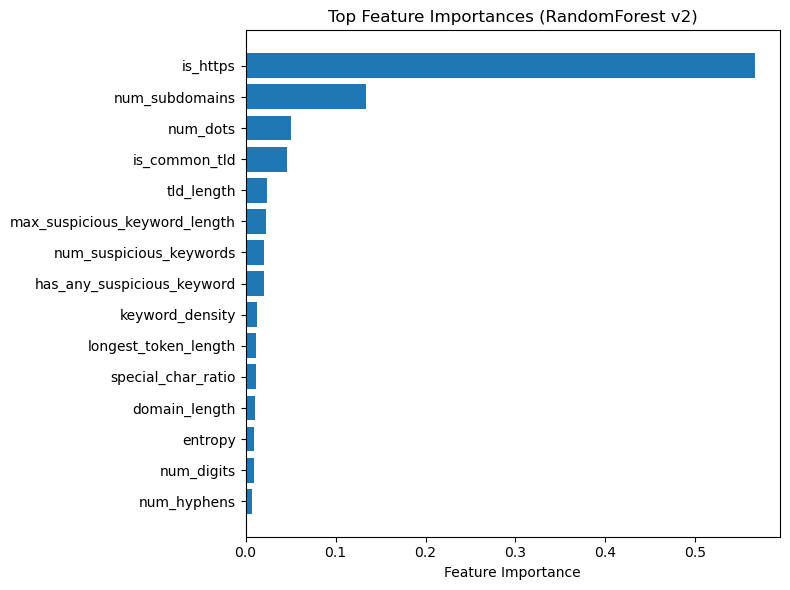

In [58]:
import matplotlib.pyplot as plt

TOP_N = 15

plt.figure(figsize=(8, 6))
plt.barh(
    fi["feature"].head(TOP_N)[::-1],
    fi["importance"].head(TOP_N)[::-1]
)
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (RandomForest v2)")
plt.tight_layout()
plt.show()